# Population Estimates: Process existing Cloud Factory annotations

We submitted ~700 tiles for CF to review prior to performing the population estimates. These tiles covered the same geographic areas for 2016, 2018 and 2020, and were sampled via random sampling stratified at the CBG-level. For this reason, although a CBG may not have been fully reviewed by CF, we assume that the 1 or 2 tiles reviewed for the CBG are representative of the small building density (number of small buildings per parcel) for the CBG. 

In [1]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

# Load sources for each year
TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * CF annotations
CF_LABELS = pd.read_csv(os.path.join(OAK_FP, 'CloudFactory_phase1/cf_coords.csv'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])

# * Building footprints (to correct CF labels on tile edges)
#building_footprints_infer = {}
#for year in ['2016', '2018', '2020']:
#    building_footprints_infer[year] = gpd.read_file(
#        os.path.join(OAK_FP, 'outputs/cbg-inference-{}/inference_building_processed'.format(year)))

100%|██████████| 3324/3324 [00:00<00:00, 16364.85it/s]


## 1. Identify the universe of parcels annotated by CF

CF_parcels contains the 18k parcels that were reviewed by Cloud Factory in 2016, 2018 and 2020. 

In [4]:
# Convert to GDF
CF_LABELS = gpd.GeoDataFrame(
    CF_LABELS, geometry=gpd.points_from_xy(CF_LABELS.longitude, CF_LABELS.latitude), crs='EPSG:4326')

In [5]:
# Collect tile names
CF_tiles = []
for cf_round in [1, 2]:
    round_path = os.path.join(
        OAK_FP, 'outputs/Temporal-Error-Analysis/Round{}/CF_Visualizations/2018'.format(cf_round))
    round_tiles = glob.glob(os.path.join(round_path, '*.png'))
    round_tiles = [tile.split(os.path.sep)[-1].replace('-small_2018.png', '') for tile in round_tiles]
    CF_tiles.extend(round_tiles)

In [6]:
# Collect tile geometries
CF_area_coverage = tiles_gdf['2020'].copy()
CF_area_coverage = CF_area_coverage.loc[CF_area_coverage['file'].isin(CF_tiles)]
CF_area_coverage.to_file(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'CF_area_coverage'))

In [7]:
# Collect associated parcels
CF_parcels = sj_parcels_cbgs.sjoin(CF_area_coverage, how='left', predicate='intersects')
CF_parcels = CF_parcels.loc[~CF_parcels['index_right'].isna()]
CF_parcels.drop('index_right', axis=1, inplace=True)

# Drop duplicate parcels (these are caused by parcels that belong to more than 1 tile)
CF_parcels.drop_duplicates('APN', inplace=True)
CF_parcels.drop('file', axis=1, inplace=True)

In [92]:
# CF annotated 17,973 (16,771 after residential and area filtering) unique parcels
# in total, for three years
len(CF_parcels)

16771

In [9]:
CF_LABELS.head()

,latitude,longitude,year,label,geometry
0,37.347625,-121.875469,2016,model_found_building,POINT (-121.87547 37.34763)
1,37.346976,-121.874903,2016,model_found_building,POINT (-121.87490 37.34698)
2,37.347096,-121.874989,2016,model_found_building,POINT (-121.87499 37.34710)
3,37.348262,-121.874701,2016,model_found_building,POINT (-121.87470 37.34826)
4,37.346881,-121.877431,2016,model_found_building,POINT (-121.87743 37.34688)


[INFO] Cloud factory area coverage (blue) and Cloud Factory small building annotations


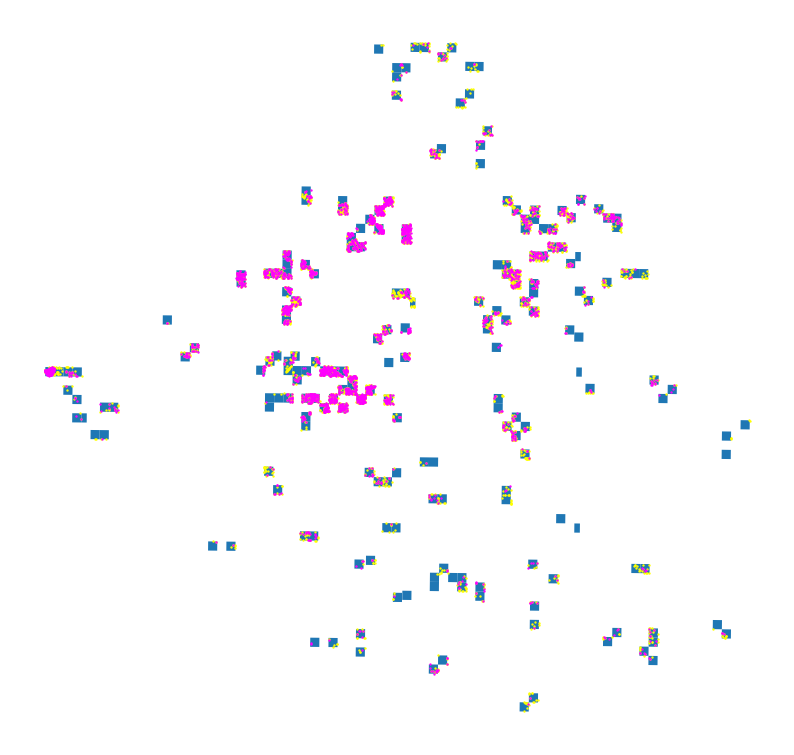

In [10]:
print('[INFO] Cloud factory area coverage (blue) and Cloud Factory small building annotations')
fig, ax = plt.subplots(figsize=(10, 10))
CF_area_coverage.plot(ax=ax)
CF_LABELS.loc[CF_LABELS['year'] == 2020].plot(ax=ax, markersize=0.5, color='yellow')
CF_LABELS.loc[CF_LABELS['year'] == 2016].plot(ax=ax, markersize=0.5, color='magenta')
#CF_LABELS.loc[CF_LABELS['year'] == 2018].plot(ax=ax, markersize=0.5, color='red')
ax.axis('off')
plt.show()

In [8]:
# Get neighborhood shapefiles
neighborhoods = cbg_income_2016_SJ.dissolve('neighborho').reset_index()
neighborhoods = neighborhoods[['neighborho', 'geometry']]

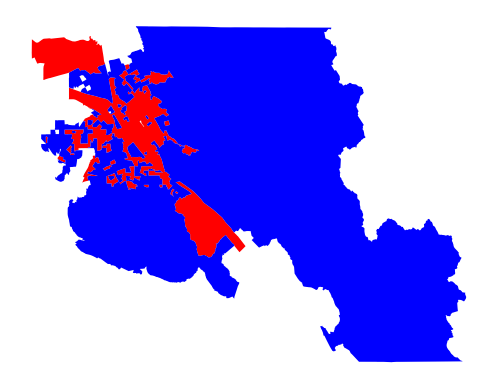

In [10]:
# Visualize neighborhoods
fig, ax = plt.subplots()
neighborhoods.loc[neighborhoods['neighborho'] == 'low'].plot(ax=ax, color='red')
neighborhoods.loc[neighborhoods['neighborho'] == 'high'].plot(ax=ax, color='blue')
ax.axis('off')
plt.show()

In [9]:
# Add neighborhood to CF_parcels
CF_parcels = pd.merge(
    CF_parcels, cbg_income_2016_SJ[['GEOID', 'neighborho']], how='left', validate='many_to_one'
)

In [14]:
# Number of parcels reviewed in each neighborhood type
# CF annotations have higher parcels in low-income neighborhood
CF_parcels.groupby('neighborho')['APN'].count().reset_index()

,neighborho,APN
0,high,8059
1,low,8712


## 2. Remove CF annotations allowing for large buildings on tile edges
We remove annotations classified as model_found_building that are actually large buildings in our building footprints. 

This strategy doesn't seem to work too well--picks up on some large buildings but several small buildings as well (perhaps due to mistakes in model inferences?) and fails to drop most large buildings, especially in earlier years. 

In [12]:
# For this universe of parcels, CF annotated 8,943 points related to potential
# small buildings (across all three yearss). Potential because large buildings 
# on tile edges were classified
# by CF as "mode_found_building" so as to not penalize model performance for this 
# tile clipping effect.
CF_LABELS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8943 entries, 0 to 8942
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   8943 non-null   float64 
 1   longitude  8943 non-null   float64 
 2   year       8943 non-null   int64   
 3   label      8943 non-null   object  
 4   geometry   8943 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 349.5+ KB


In [15]:
# Get large buildings for each year
#large_bfi = gpd.GeoDataFrame()
#for year, gdf in building_footprints_infer.items():
#    gdf['year'] = year
#    large_bfi = pd.concat([large_bfi, gdf])
#large_bfi = large_bfi.loc[large_bfi['small'] == 0]

In [16]:
# Remove CF Labels of type "model_found_building" that reside on large buildings
#CF_LABELS_p1 = CF_LABELS.loc[CF_LABELS['label'] != 'model_found_building'].copy()
#CF_LABELS_p2 = CF_LABELS.loc[CF_LABELS['label'] == 'model_found_building'].copy()

In [19]:
#CF_LABELS_p2_corrected = gpd.GeoDataFrame()
#for year in ['2016', '2018', '2020']:
#    print('[INFO] Year: {}'.format(year))
#    cf_labels_year = CF_LABELS_p2.loc[CF_LABELS_p2['year'] == int(year)].copy()
#    large_bfi_year = large_bfi.loc[large_bfi['year'] == year].copy()
    
#    # Check for overlap with large buildings
#    n_labels = len(cf_labels_year)
#    print('[INFO] Number of labels: {}'.format(n_labels))
#    cf_labels_year = cf_labels_year.sjoin(
#        large_bfi_year[['geometry']], how='left', predicate='intersects')
    
#    assert len(cf_labels_year) == n_labels
    
    # Keep annotations that do not overlap with a large building
#    a = cf_labels_year.loc[~cf_labels_year['index_right'].isna()]
#    cf_labels_year = cf_labels_year.loc[cf_labels_year['index_right'].isna()]

#    print('[INFO] Number of labels after dropping large buildings: {}'.format(len(cf_labels_year)))
    
    # Append to corrected dataframe
#    CF_LABELS_p2_corrected = pd.concat([CF_LABELS_p2_corrected, cf_labels_year])

[INFO] Year: 2020
[INFO] Number of labels: 2222
[INFO] Number of labels after dropping large buildings: 2152


In [22]:
#a

,latitude,longitude,year,label,geometry,index_right
119,37.346789,-121.874526,2020,model_found_building,POINT (-121.87453 37.34679),202299.0
140,37.207648,-121.830395,2020,model_found_building,POINT (-121.83040 37.20765),142993.0
591,37.306186,-121.897636,2020,model_found_building,POINT (-121.89764 37.30619),88691.0
726,37.298945,-121.884426,2020,model_found_building,POINT (-121.88443 37.29895),40765.0
1207,37.319417,-121.884598,2020,model_found_building,POINT (-121.88460 37.31942),159794.0
...,...,...,...,...,...,...
8760,37.307936,-121.908437,2020,model_found_building,POINT (-121.90844 37.30794),89626.0
8772,37.307948,-121.908565,2020,model_found_building,POINT (-121.90857 37.30795),89626.0
8794,37.307954,-121.905180,2020,model_found_building,POINT (-121.90518 37.30795),89512.0
8796,37.308852,-121.905167,2020,model_found_building,POINT (-121.90517 37.30885),89455.0


In [22]:
# Concatenate with other two labels 
#CF_LABELS = pd.concat([CF_LABELS_p1, CF_LABELS_p2_corrected[CF_LABELS_p1.columns]])

In [35]:
CF_LABELS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8943 entries, 0 to 8942
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   8943 non-null   float64 
 1   longitude  8943 non-null   float64 
 2   year       8943 non-null   int64   
 3   label      8943 non-null   object  
 4   geometry   8943 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 349.5+ KB


In [15]:
# CF number of small buildings found in each year
CF_LABELS.groupby('year').count().reset_index()

,year,latitude,longitude,label,geometry
0,2016,2869,2869,2869,2869
1,2018,2228,2228,2228,2228
2,2020,3846,3846,3846,3846


## 3. Compute parcel-level and CBG-level measures

### 3.1 Small building density

In [40]:
cbg_density = pd.DataFrame()
parcel_density = pd.DataFrame()
for year in ['2016', '2018', '2020']:
    parcel_density_year = CF_parcels.copy()
    cf_labels_year = CF_LABELS.loc[CF_LABELS['year'] == int(year)]
    
    # Assign CF points to parcels
    parcel_density_year = parcel_density_year.sjoin(cf_labels_year, how='left')
    
    # Parcel density
    parcel_density_year = parcel_density_year.groupby(
        ['APN', 'GEOID'])['index_right'].count().reset_index()
    parcel_density_year['year'] = year
    
    # Aggregate at the CBG level (gives the mean density of the parcels reviewed by CF in a CBG)
    cbg_density_year = parcel_density_year.groupby('GEOID').agg(
        {'index_right': ['mean', 'std', 'count']}).reset_index()
    cbg_density_year.columns = ['-'.join(l) if l[1] != '' else l[0] for l in cbg_density_year.columns]
    
    cbg_density_year.rename(columns={'index_right-mean': 'mean_density', 
                                     'index_right-std': 'std_density', 
                                    'index_right-count': 'N_parcels_sampled'}, inplace=True)
    cbg_density_year['year'] = year
    
    # Append
    cbg_density = pd.concat([cbg_density, cbg_density_year])
    
    parcel_density_year.rename(columns={'index_right': 'parcel_density'}, inplace=True)
    parcel_density = pd.concat([parcel_density, parcel_density_year])

In [41]:
# Add neighborhood type
cbg_density = pd.merge(
    cbg_density, cbg_income_2016_SJ[['GEOID', 'neighborho', 'geometry']], how='left', 
    validate='many_to_one')

parcel_density = pd.merge(
    parcel_density, cbg_income_2016_SJ[['GEOID', 'neighborho']], how='left', validate='many_to_one'
)

In [90]:
# Save
parcel_density.to_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density.csv'), index=False)

cbg_density['GEOID'] = cbg_density['GEOID'].astype(str)
cbg_density[['GEOID', 'mean_density', 'std_density', 'N_parcels_sampled', 'year', 'neighborho']].to_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'cbg_density.csv'), index=False)

The total growth in small buildings in this area per CF annotations is 963 added small buildings from 2016 to 2020, 362 in high income neighborhoods and 601 in low income neighborhoods.

In [26]:
# Parcel-level small building stats
a = parcel_density.groupby(['year', 'neighborho'])['parcel_density'].sum().reset_index()
a.pivot(index='neighborho', columns='year').reset_index()

neighborho parcel_density            
year                      2016  2018  2020
0          high           1161   812  1523
1           low           1664  1383  2265

### 3.2 Small building growth
Note: We assume there are no small building demolitions. I.e., we simply have to check whether small buildings in 2020 existed in 2016. 

In [42]:
"""
apn = '23031033'
CF_parcel = CF_parcels.loc[CF_parcels['APN'] == apn].copy()

CF_parcel_labels = CF_LABELS.sjoin(CF_parcel, how='left', predicate='intersects').copy()
CF_parcel_labels = CF_parcel_labels.loc[~CF_parcel_labels['index_right'].isna()]
CF_parcel_labels = CF_parcel_labels.loc[CF_parcel_labels['year'] != 2018]
CF_parcel_labels.drop('index_right', axis=1, inplace=True)

# Check if the 2020 and 2016 buildings overlap
parcel_2016 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2016].copy()
parcel_2020 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2020].copy()
parcel_2020.reset_index(inplace=True, drop=True)
n_2020_builds = len(parcel_2020)

parcel_2020.geometry = parcel_2020.to_crs('EPSG:26910').buffer(POINT_BUFFER).to_crs('EPSG:4326')
parcel_2020 = parcel_2020.sjoin(parcel_2016[['geometry']], how='left', predicate='intersects')

# Select only 2020 buildings that did not have a match in 2016
#parcel_2020 = parcel_2020.loc[parcel_2020['index_right'].isna()]
#parcel_2020 = parcel_2020.reset_index().drop_duplicates(subset='index')

parcel_sbuild = parcel_2020.copy()
parcel_sbuild = parcel_sbuild.reset_index().drop_duplicates(subset='index')
"""

In [10]:
POINT_BUFFERS = [3]

for POINT_BUFFER in POINT_BUFFERS:
    print('[INFO] Buffer: {}'.format(POINT_BUFFER))

    parcel_growth_path = os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_{}.csv'.format(POINT_BUFFER))
    sbuild_2020_path = os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'sbuild_2020_{}.csv'.format(POINT_BUFFER))
    sbuild_2020_cols = ['latitude', 'longitude', 'year', 'new_sbuilding', 'APN', 'GEOID']
    if not os.path.exists(parcel_growth_path) or not os.path.exists(sbuild_2020_path):
        parcel_growth = pd.DataFrame()
        sbuild_2020 = pd.DataFrame()
        reviewed_parcels = []
    else:
        parcel_growth = pd.read_csv(parcel_growth_path)
        sbuild_2020 = pd.read_csv(sbuild_2020_path)
        reviewed_parcels = parcel_growth['APN'].unique()

    print('[INFO] Number of reviewed parcels: {}'.format(len(reviewed_parcels)))
    
    for i, apn in tqdm(enumerate(CF_parcels['APN'].unique())):
        if apn in reviewed_parcels:
            continue

        # Get annotations within the parcel
        CF_parcel = CF_parcels.loc[CF_parcels['APN'] == apn].copy()

        CF_parcel_labels = CF_LABELS.sjoin(CF_parcel, how='left', predicate='intersects').copy()
        CF_parcel_labels = CF_parcel_labels.loc[~CF_parcel_labels['index_right'].isna()]
        CF_parcel_labels = CF_parcel_labels.loc[CF_parcel_labels['year'] != 2018]
        CF_parcel_labels.drop('index_right', axis=1, inplace=True)

        # Edge cases: no buildings in 2020, or no buildings in 2016
        if 2020 not in CF_parcel_labels['year'].unique():
            parcel_new_build = pd.DataFrame.from_dict({'APN': [apn], 'new_small_build': [0]})

        if 2016 not in CF_parcel_labels['year'].unique():
            # Compute number of new small buildings and append
            parcel_new_build = pd.DataFrame.from_dict(
                {'APN': [apn], 'new_small_build': [len(CF_parcel_labels)]})
            CF_parcel_labels['new_sbuilding'] = True
            parcel_sbuild = CF_parcel_labels[sbuild_2020_cols].copy()
        
        if 2020 in CF_parcel_labels['year'].unique() and 2016 in CF_parcel_labels['year'].unique():
            # Check if the 2020 and 2016 buildings overlap
            parcel_2016 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2016].copy()
            parcel_2020 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2020].copy()
            parcel_2020.reset_index(inplace=True, drop=True)
            parcel_2020['index'] = parcel_2020.index
            n_2020_builds = len(parcel_2020)

            parcel_2020.geometry = parcel_2020.to_crs('EPSG:26910').buffer(POINT_BUFFER).to_crs('EPSG:4326')
            parcel_2020 = parcel_2020.sjoin(parcel_2016[['geometry']], how='left', predicate='intersects')
            parcel_2020['new_sbuilding'] = parcel_2020['index_right'].isna()
            parcel_2020.sort_values('new_sbuilding', ascending=False, inplace=True)
            parcel_2020.drop_duplicates('index', keep='last', inplace=True)

            # Get 2020 small buildings and define which are newly built
            parcel_sbuild = parcel_2020.copy()
            
            # Select only 2020 buildings that did not have a match in 2016
            parcel_2020 = parcel_2020.loc[parcel_2020['new_sbuilding'] == True]
            parcel_new_build = pd.DataFrame.from_dict(
                    {'APN': [apn], 'new_small_build': [len(parcel_2020)]})

            assert len(parcel_2020) <= n_2020_builds
            assert len(parcel_sbuild) <= n_2020_builds
            
        parcel_growth = pd.concat([parcel_growth, parcel_new_build])
        sbuild_2020 = pd.concat([sbuild_2020, parcel_sbuild])
        
        if i % 50 == 0 or i == len(CF_parcels['APN'].unique()):
            parcel_growth.to_csv(parcel_growth_path, index=False)
            sbuild_2020.to_csv(sbuild_2020_path, index=False)

[INFO] Buffer: 3
[INFO] Number of reviewed parcels: 0


16771it [2:42:32,  1.72it/s]


Buffer example

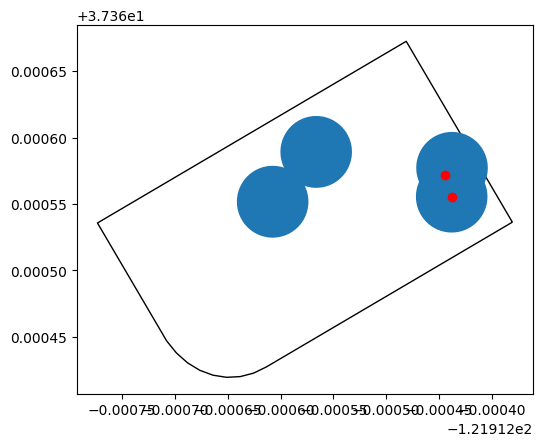

In [33]:
apn='23031006'
apn='23031033'
POINT_BUFFER = 3

# Get annotations within the parcel
CF_parcel = CF_parcels.loc[CF_parcels['APN'] == apn].copy()

CF_parcel_labels = CF_LABELS.sjoin(CF_parcel, how='left', predicate='intersects').copy()
CF_parcel_labels = CF_parcel_labels.loc[~CF_parcel_labels['index_right'].isna()]
CF_parcel_labels = CF_parcel_labels.loc[CF_parcel_labels['year'] != 2018]
CF_parcel_labels.drop('index_right', axis=1, inplace=True)

parcel_2016 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2016].copy()
parcel_2020 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2020].copy()
parcel_2020.reset_index(inplace=True, drop=True)
n_2020_builds = len(parcel_2020)

parcel_2020.geometry = parcel_2020.to_crs('EPSG:26910').buffer(POINT_BUFFER).to_crs('EPSG:4326')
  
# Plot
fig, ax = plt.subplots()
CF_parcel.plot(ax=ax, facecolor='none')
parcel_2020.plot(ax=ax)
parcel_2016.plot(ax=ax, color='red')
plt.show()

### 3.3 Permits
Compute permitted and unpermitted small buildings and new small buildings. 

In [156]:
# Aggregate permits at the parcel level to figure out number of permits per parcel
parcel_permits = permits.groupby(['APN_parcel', 'issue_year'])['OBJECTID_left'].count().reset_index()
parcel_permits = parcel_permits.pivot(
    index='APN_parcel', columns='issue_year', values='OBJECTID_left').reset_index()

# Count number of permits pre-2015 and pre-2021
pre_15_cols = [c for c in parcel_permits.columns if (type(c) == int) and c < 2015]
pre_17_cols = [c for c in parcel_permits.columns if (type(c) == int) and c < 2017]
pre_21_cols = [c for c in parcel_permits.columns if (type(c) == int) and c < 2021]

parcel_permits['<=2014'] = parcel_permits.apply(lambda row: row[pre_15_cols].sum(), axis=1)
parcel_permits['<=2016'] = parcel_permits.apply(lambda row: row[pre_17_cols].sum(), axis=1)
parcel_permits['<=2020'] = parcel_permits.apply(lambda row: row[pre_21_cols].sum(), axis=1)
parcel_permits['2015_20'] = parcel_permits.apply(lambda row: row['<=2020'] - row['<=2014'], axis=1)

parcel_permits = parcel_permits[['APN_parcel', '<=2016', '<=2020', '2015_20']]
parcel_permits.rename(columns={'APN_parcel': 'APN'}, inplace=True)

#### 3.3.1 Small buildings in 2016 and in 2020
Assumptions:
No small building demolitions, No small building conversions (permits aren't acquired retroactively)

In [157]:
# Merge permit and small building data
parcel_density_permitted = parcel_density.copy()
parcel_density_permitted = pd.merge(
    parcel_density_permitted, parcel_permits[['APN', '<=2016', '<=2020', '2015_20']], on='APN', 
    how='left', validate='many_to_one')

# Fill parcel columns with zeros
parcel_density_permitted[['<=2016', '<=2020', '2015_20']] = parcel_density_permitted[
    ['<=2016', '<=2020', '2015_20']].fillna(value=0)

# Drop 2018 data
parcel_density_permitted = parcel_density_permitted.loc[parcel_density_permitted['year'] != '2018']

In [158]:
# Impose no demolition assumption by ensuring density in 2020 is >= as in 2016
# Note this adds about 1000 small buildings in 2020
parcel_density_permitted = parcel_density_permitted.pivot(
    index=['APN', 'GEOID', 'neighborho', '<=2016', '<=2020', '2015_20'], 
    columns='year', values='parcel_density').reset_index()
parcel_density_permitted.rename(columns={'2016': '2016_sb', '2020': '2020_sb'}, inplace=True)

parcel_density_permitted['2020_sb'] = parcel_density_permitted.apply(
    lambda row: max(row['2020_sb'], row['2016_sb']), axis=1)

In [159]:
# Compute unpermitted and permitted small building density at the parcel level
parcel_density_permitted['permitted_sb_2016'] = parcel_density_permitted.apply(
    lambda row: min(row['2016_sb'], row['<=2016']), axis=1)

def compute_2020_permitted_units(row):    
    # New buildings
    new_sbuild = row['2020_sb'] - row['2016_sb']
    new_permitted_sbuild = min(new_sbuild, row['2015_20'])
    return row['permitted_sb_2016'] + new_permitted_sbuild
parcel_density_permitted['permitted_sb_2020'] = parcel_density_permitted.apply(
    lambda row: compute_2020_permitted_units(row), axis=1)

for year in ['2016', '2020']:
    parcel_density_permitted['unpermitted_sb_{}'.format(year)] = parcel_density_permitted[
        '{}_sb'.format(year)] - parcel_density_permitted['permitted_sb_{}'.format(year)]

In [160]:
# Compute change in permitted and unpermitted change
for rate_kind in ['permitted', 'unpermitted']:
    parcel_density_permitted['{}_change'.format(rate_kind)] = parcel_density_permitted.apply(
        lambda row: max(0, row['{}_sb_2020'.format(rate_kind)] - row['{}_sb_2016'.format(rate_kind)]),
        axis=1)

In [161]:
print('[INFO] Number of parcels: {}'.format(len(parcel_density_permitted['APN'].unique())))

# Save
parcel_density_permitted.to_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density_permitted.csv'))

[INFO] Number of parcels: 16771


#### 3.3.2 New small buildings during 2016-2020

In [162]:
# Merge permit and small building data
parcel_growth_permitted = parcel_growth.copy()
parcel_growth_permitted = pd.merge(
    parcel_growth_permitted, parcel_permits[['APN', '2015_20']], on='APN', 
    how='left', validate='many_to_one')

# Fill parcel columns with zeros
parcel_growth_permitted[['2015_20']] = parcel_growth_permitted[['2015_20']].fillna(value=0)

# Compute unpermitted and permitted new small buildings at the parcel level
parcel_growth_permitted['permitted_change'] = parcel_growth_permitted.apply(
    lambda row: min(row['new_small_build'], row['2015_20']), axis=1)
parcel_growth_permitted['unpermitted_change'] = parcel_growth_permitted[
    'new_small_build'] - parcel_growth_permitted['permitted_change']

assert parcel_growth_permitted['unpermitted_change'].sum() + parcel_growth_permitted[
    'permitted_change'].sum() == parcel_growth_permitted['new_small_build'].sum()

# Add GEOID
parcel_growth_permitted = pd.merge(
    parcel_growth_permitted, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

parcel_growth_permitted.to_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_permitted_{}.csv'.format(POINT_BUFFER)))

### 3.3.3 Assigning permits by snapping to nearest building
We snap the permits to the nearest small building (within a distance threshold as defined by `MAX_DIST_LIST`). 

In [19]:
# All small buildings in 2020 (and whether they're newly built after 2016)
POINT_BUFFER = 3
MAX_DIST_LIST = [50, 80, 100, 200, 400]
sbuild_2020_path = os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'sbuild_2020_{}.csv'.format(POINT_BUFFER))
sbuild_2020 = pd.read_csv(sbuild_2020_path, dtype={'GEOID': str})
sbuild_2020.drop('index_right', inplace=True, axis=1)
sbuild_2020['sbuild_index'] = sbuild_2020.index

# Convert to GDF
sbuild_2020 = gpd.GeoDataFrame(
    sbuild_2020, geometry=gpd.points_from_xy(sbuild_2020.longitude, sbuild_2020.latitude), 
    crs='EPSG:4326')

# Subset permits to 2015-2020
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

permits_2015_20 = gpd.GeoDataFrame(
    permits_2015_20, geometry='geometry_permit', crs='EPSG:4326')
permits_2015_20.reset_index(inplace=True, drop=True)
permits_2015_20['permit_index'] = permits_2015_20.index
n_permits_2015_20 = len(permits_2015_20)

In [20]:
# Snap permits to nearest small building (within a threshold)
for MAX_DIST in MAX_DIST_LIST:
    # -- 1. Assign permits to nearest small building in 2020 
    # * Create a buffer around the building
    sbuild_2020_buff = sbuild_2020.to_crs('EPSG:26910').copy()
    sbuild_2020_buff['centroid'] = sbuild_2020_buff['geometry']
    sbuild_2020_buff['geometry'] = sbuild_2020_buff.buffer(MAX_DIST)
    
    # * Join permits and small buildings
    permits_2015_20_snap = permits_2015_20[
        ['OBJECTID_left', 'issue_year', 'geometry_permit', 'permit_index']].to_crs('EPSG:26910').sjoin(
        sbuild_2020_buff[['geometry', 'centroid', 'sbuild_index']], how='left', predicate='intersects')

    # * Drop permits that do not match to buildings
    permits_2015_20_snap = permits_2015_20_snap.loc[~permits_2015_20_snap['index_right'].isna()]

    # * Compute distance
    permits_2015_20_snap['distance'] = permits_2015_20_snap['geometry_permit'].distance(
        permits_2015_20_snap['centroid'])

    # * Order permits by closest distance and drop duplicates
    permits_2015_20_snap.sort_values('distance', ascending=True, inplace=True)
    permits_2015_20_snap.drop_duplicates(subset='permit_index', keep='first', inplace=True)
    assert len(permits_2015_20_snap) <= len(permits_2015_20['permit_index'].unique())

    print('[INFO] {} permits issues during 2015-20'.format(len(permits_2015_20['permit_index'].unique())))
    print('[INFO] {} permits assigned to small buildings using max distance of {}'. format(
        len(permits_2015_20_snap), MAX_DIST))

    # -- 2. Define permitted new small buildings
    permits_2015_20_snap['index_right'] = permits_2015_20_snap['index_right'].astype(int)
    permits_2015_20_snap['sbuild_index'] = permits_2015_20_snap['sbuild_index'].astype(int)

    sbuild_2020_permitted = pd.merge(
        sbuild_2020, permits_2015_20_snap[['sbuild_index', 'OBJECTID_left', 'issue_year']], how='left', 
        on='sbuild_index', validate='one_to_many')
    sbuild_2020_permitted['permitted'] = ~sbuild_2020_permitted['OBJECTID_left'].isna()
    
    # Keep only one permit per building (to not duplicate small buildings)
    sbuild_2020_permitted.sort_values('permitted', ascending=False, inplace=True)
    sbuild_2020_permitted.drop_duplicates('sbuild_index', keep='last', inplace=True)
    
    # -- 3. Aggregate at the parcel level (just consider parcel growth)
    parcel_growth_permitted_snap = sbuild_2020_permitted.copy()
    parcel_growth_permitted_snap = parcel_growth_permitted_snap.loc[
        parcel_growth_permitted_snap['new_sbuilding'] == True]

    parcel_growth_permitted_snap['permitted'] = ~parcel_growth_permitted_snap['OBJECTID_left'].isna()
    parcel_growth_permitted_snap = parcel_growth_permitted_snap.groupby(['APN', 'GEOID'])[
        ['new_sbuilding', 'permitted']].sum().reset_index()
    
    parcel_growth_permitted_snap.rename(
        columns={'new_sbuilding': 'total_change', 'permitted': 'permitted_change'}, inplace=True)
    parcel_growth_permitted_snap['unpermitted_change'] = parcel_growth_permitted_snap['total_change'] - parcel_growth_permitted_snap['permitted_change']
    assert parcel_growth_permitted_snap['unpermitted_change'].min() >= 0
    
    # -- 4. Fill with zeros (for parcels that had no new buildings)
    parcel_growth_permitted_snap = pd.merge(
        CF_parcels[['APN', 'GEOID']], 
        parcel_growth_permitted_snap[['APN', 'total_change', 'permitted_change', 'unpermitted_change']], 
        on='APN', how='left', validate='one_to_one')
    parcel_growth_permitted_snap.fillna(0, inplace=True)
    
    # -- 5. Save
    parcel_growth_permitted_snap.to_csv(os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_permitted_snap_{}_{}.csv'.format(
            POINT_BUFFER, MAX_DIST)))

[INFO] 5140 permits issues during 2015-20
[INFO] 249 permits assigned to small buildings using max distance of 50
[INFO] 5140 permits issues during 2015-20
[INFO] 384 permits assigned to small buildings using max distance of 80
[INFO] 5140 permits issues during 2015-20
[INFO] 506 permits assigned to small buildings using max distance of 100
[INFO] 5140 permits issues during 2015-20
[INFO] 998 permits assigned to small buildings using max distance of 200
[INFO] 5140 permits issues during 2015-20
[INFO] 1801 permits assigned to small buildings using max distance of 400


In [12]:
# Checks
POINT_BUFFER = 3
MAX_DIST_LIST = [50, 80, 100, 200, 400]
for MAX_DIST in MAX_DIST_LIST:
    parcel_growth_permitted_snap = pd.read_csv(os.path.join(
            OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_permitted_snap_{}_{}.csv'.format(
                POINT_BUFFER, MAX_DIST)))
    print('Permit buffer: {}'.format(MAX_DIST))
    print('Proportion of permitted new buildings: {}%'.format(round(
        100 * parcel_growth_permitted_snap['permitted_change'].sum() / parcel_growth_permitted_snap['total_change'].sum(), 
        2)))

parcel_growth = pd.read_csv(os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_{}.csv'.format(POINT_BUFFER)))

Permit buffer: 50
Proportion of permitted new buildings: 5.55%
Permit buffer: 80
Proportion of permitted new buildings: 8.51%
Permit buffer: 100
Proportion of permitted new buildings: 10.36%
Permit buffer: 200
Proportion of permitted new buildings: 17.38%
Permit buffer: 400
Proportion of permitted new buildings: 24.04%


## 4. Power Analysis inputs

### 4.1 Neyman allocation and parcel confidences for CF parcels

In [10]:
# Load parcel confidences and subset to CF area
parcel_conf_df = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Confidences', 'parcel-confidence.csv'), 
    dtype={'GEOID': str})    
parcel_conf_df = parcel_conf_df.loc[parcel_conf_df['APN'].isin(CF_parcels['APN'].unique())]

# Load parcel growth data
POINT_BUFFER = 3
parcel_growth_permitted = pd.read_csv(os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_permitted_{}.csv'.format(POINT_BUFFER)))
parcel_growth = pd.read_csv(os.path.join(
        OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth_{}.csv'.format(POINT_BUFFER)))

# Load parcel density
parcel_density = pd.read_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density.csv'), 
    dtype={'GEOID': str})

In [12]:
parcel_growth.head()

,APN,new_small_build
0,70616068,0
1,23032111,0
2,43948043,0
3,43941077,0
4,42132050,0


In [33]:
# Check that all CF parcels have computed parcel confidences
finalized = parcel_conf_df['APN'].unique()
x = CF_parcels['APN'].isin(finalized)
print('[INFO]: {} parcels / {} parcels'.format(x.sum(), len(CF_parcels['APN'].unique())))

[INFO]: 16770 parcels / 16771 parcels


In [34]:
# Add high/low neighborhood (defined by 75 percentile)
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

parcel_conf_df = pd.merge(
    parcel_conf_df, cbg_income_2016_SJ[['GEOID', 'quartile']], how='left', 
    validate='many_to_one')

parcel_conf_df['neighborhood(75)'] = parcel_conf_df['quartile'].apply(
    lambda q: 'High' if int(q.split('IS_')[1]) == 3 else 'Low')

In [35]:
# Generate income-confidence bins: we cut parcel confidences into low confidence (< 0.5) and
# high confidence (> 0.5)
parcel_conf_df['CBin'] = pd.cut(parcel_conf_df['confidence'], bins=2, labels=False)
parcel_conf_df['CBin'] = parcel_conf_df['CBin'].fillna(value= 'None')

parcel_conf_df['Bin'] = parcel_conf_df.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['CBin']), axis=1)

In [36]:
# Add Y_ij
#note we compute this as the average density across years as the parcel level
# given that we sample parcels, not parcel-years.
#Y_ij = parcel_density.groupby('APN')['parcel_density'].mean().reset_index()

# Y_ij is the permitted proportion of new small buildings in the parcel. We use
# a value of 0 if there were no new small buildings between 2016 and 2020. 
parcel_growth_permitted['permitted_ratio'] = parcel_growth_permitted.apply(
    lambda row: 0 if row['new_small_build'] == 0  else row['permitted_change'] / row['new_small_build'], 
    axis=1)
Y_ij = parcel_growth_permitted[['APN', 'permitted_ratio']]

parcel_conf_df = pd.merge(parcel_conf_df, Y_ij, how='left', validate='one_to_one')

In [39]:
# Add parcel new small buildings
# Computation #1 (using parcel-level computations)
sb_growth = parcel_density.copy()
sb_growth = sb_growth.loc[sb_growth['year'] != '2018']
sb_growth = sb_growth.pivot(
    index=['APN', 'GEOID'], columns='year', values='parcel_density').reset_index()

sb_growth['num_new_sbs'] = sb_growth.apply(
    lambda row: max(0, row[2020] - row[2016]), axis=1)
sb_growth.rename(columns={'num_new_sbs': 'new_small_build_C1'}, inplace=True)

parcel_conf_df = pd.merge(
    parcel_conf_df, sb_growth[['APN', 'new_small_build_C1']], how='left', validate='one_to_one')

# Computation #2 (using building-level computations)
parcel_conf_df = pd.merge(
    parcel_conf_df, parcel_growth[['APN', 'new_small_build']], how='left', validate='one_to_one')
parcel_conf_df.rename(columns={'new_small_build': 'new_small_build_C2'}, inplace=True)

In [40]:
parcel_conf_df.head()

,APN,confidence,GEOID,strata_inc,quartile,neighborhood(75),CBin,Bin,permitted_ratio,new_small_build_C1,new_small_build_C2
0,58112007,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.0,0,0.0
1,58110066,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.0,0,0.0
2,58115010,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.0,0,0.0
3,58110003,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.0,0,0.0
4,48632016,NaN,060855035063,IS_12,IS_0,Low,None,IS_12-None,0.0,1,1.0


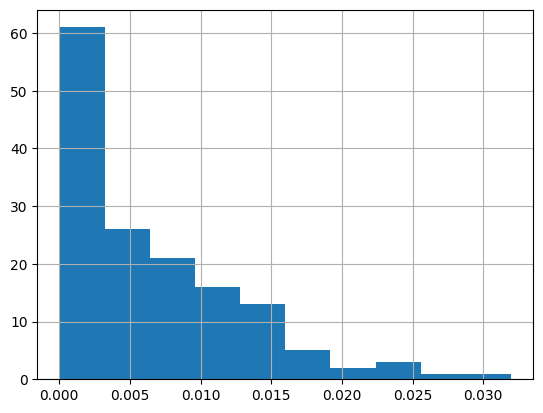

In [41]:
# Find S_j, N_j
Neyman_alloc = parcel_conf_df.groupby('Bin').agg(
    {'APN': 'count', 'permitted_ratio': 'std'}).reset_index()
Neyman_alloc.rename(columns={'APN': 'N_j', 'permitted_ratio': 'S_j'}, inplace=True)

# Smoothing: as may parcels did not have new buildings, we set S_j = min(S_j, min S_i), 
# where S_i > 0 so that each bin has a non-zero probability of being sampled from.
min_Sj = Neyman_alloc.loc[Neyman_alloc['S_j'] > 0]['S_j'].min()
Neyman_alloc['S_j'] = Neyman_alloc['S_j'].apply(
    lambda sj: sj if sj > 1e-5 else min_Sj)

Neyman_denom = (Neyman_alloc['N_j'] * Neyman_alloc['S_j']).sum()
Neyman_alloc['weight'] = Neyman_alloc.apply(
    lambda row: row['N_j'] * row['S_j'] / Neyman_denom, axis=1)

Neyman_alloc['weight'].hist()
plt.show()

assert Neyman_alloc['weight'].sum() - 1 < 1e-5

In [43]:
# Save
Neyman_alloc.to_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'PA-neyman_alloc.csv'), index=False)
parcel_conf_df.to_csv(os.path.join(
    OUTPUT_FP, 'R0_CF_Annotations', 'PA-CFparcels_{}.csv'.format(POINT_BUFFER)), index=False)

### 4.2 Aggregates for first power analysis (two-sample t-test of low vs high income small density)
Need to aggregate from the parcel level because we wish to compute the number of *parcels* that need to be reviewed.

In [128]:
aggregates_from_parcel = parcel_density.groupby(['year', 'neighborho']).agg(
    {'parcel_density': ['mean', 'std', 'count']}).reset_index()
aggregates_from_parcel.columns = ['-'.join(l) for l in aggregates_from_parcel.columns]

In [129]:
aggregates_from_parcel

,year-,neighborho-,parcel_density-mean,parcel_density-std,parcel_density-count
0,2016,high,0.130801,0.361301,8318
1,2016,low,0.177642,0.427024,9491
2,2018,high,0.090887,0.303736,8318
3,2018,low,0.148351,0.393188,9491
4,2020,high,0.173960,0.434654,8318
5,2020,low,0.242229,0.496576,9491


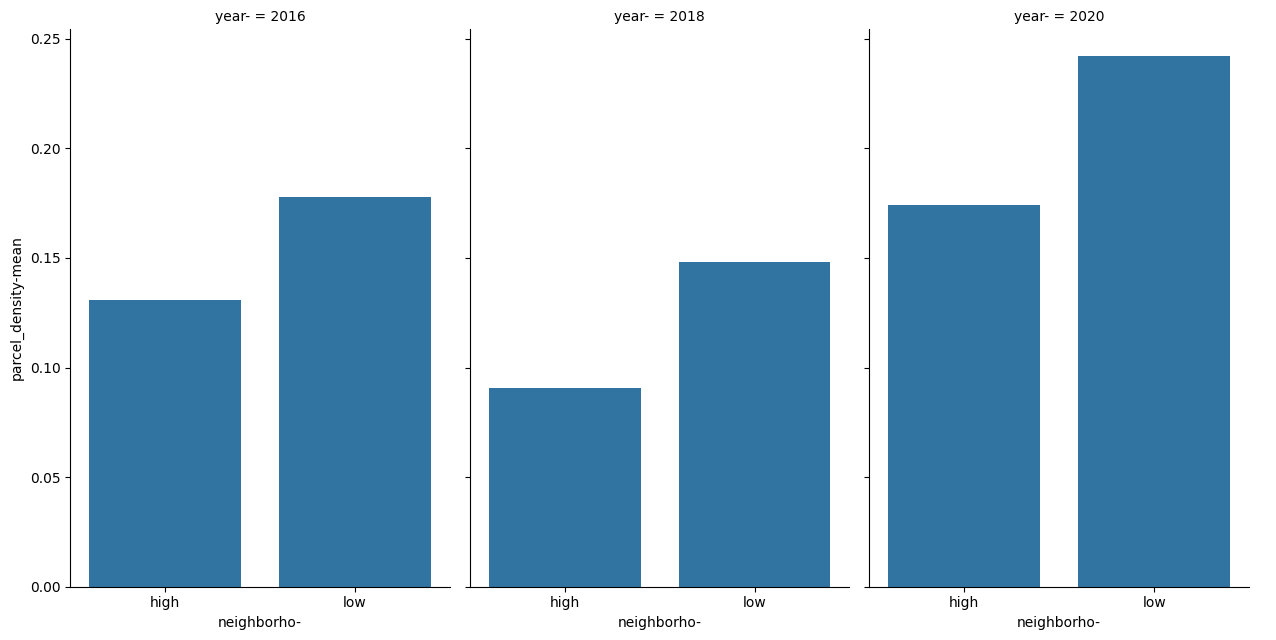

In [80]:
g = sns.FacetGrid(aggregates_from_parcel, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'parcel_density-mean')
g.add_legend()
plt.show()

### 4.3 S_j

In [184]:
cbg_density.loc[cbg_density['year'] == '2020'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 498 to 746
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         249 non-null    object  
 1   mean_density  249 non-null    float64 
 2   std_density   241 non-null    float64 
 3   year          249 non-null    object  
 4   neighborho    245 non-null    object  
 5   geometry      249 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 13.6+ KB


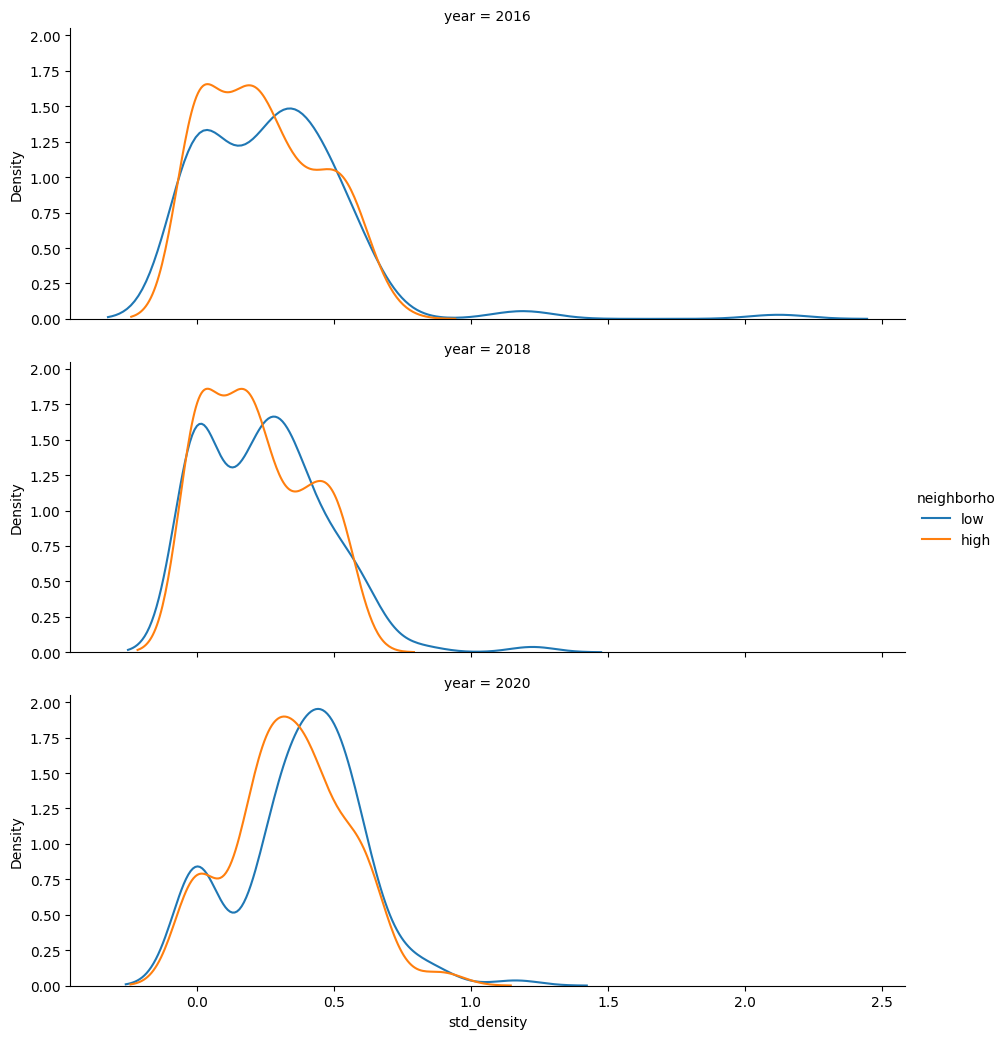

In [156]:
g = sns.FacetGrid(cbg_density, row="year", hue='neighborho', height=3.5, aspect=2.65)
g.map(sns.kdeplot, 'std_density')
g.add_legend()
plt.show()